In [1]:
import cirq
from cirq.devices import InsertionNoiseModel
import numpy as np
import matplotlib.pyplot as plt
import mitiq
from mitiq.zne.inference import LinearFactory
from mitiq.zne import execute_with_zne
from mitiq.zne.scaling import fold_global

In [2]:
def prepare_correlated(env,n=2):
    yield cirq.H(env[0])
    yield cirq.CNOT(env[0],env[1])
    yield cirq.CNOT(env[1],env[2])

def prepare_uncorrelated(env,n):
    for i in range(n):
        yield cirq.H(env[i])

def collide(env,sys,theta):
    yield cirq.CNOT(env,sys)
    yield cirq.Rz(rads=2*theta).on(sys)
    yield cirq.CNOT(env,sys)

def collision_pattern_correlated(env,sys,n,theta):
    for i in range(n):
        yield from collide(env[1+(i%2)],sys,theta)

def collision_pattern_uncorrelated(env,sys,n,theta):
    for i in range(n):
        yield from collide(env[i],sys,theta)

def meas_coherence(sys):
    yield cirq.H(sys)
    #yield cirq.measure(sys, key = 'answer')

def collision_circuit(env,sys,prepare_ancilla,collision_pattern,n,theta):
    yield cirq.H(sys)
    yield from prepare_ancilla(env,n)
    yield from collision_pattern(env,sys,n,theta)
    yield from meas_coherence(sys)

In [6]:
def corrfunc(time):
    return (np.cos(time)**2-np.sin(time)**2)/2

def uncorrfunc(i):
    return np.power(np.cos(2*g*tau),i/tau)/2

In [17]:
n = 20
g = 1
tau = np.pi/6
t = np.array(list(range(1,n+1)))*tau
theta = g*tau
rho_12_corr = []
rho_12_corr_zne = []

sys = cirq.LineQubit(0)
env = cirq.LineQubit.range(1,4)

simulator = cirq.Simulator()
repcnt = 256
linearfactory = LinearFactory(scale_factors = [1.0,2.0,3.0]) 

In [4]:
#Noise model
ops_added = {}
for q in [sys]+env:
    H_1q = cirq.OpIdentifier(cirq.H,q)
    Rz_1q = cirq.OpIdentifier(cirq.Rz,q)
    noise_1q = cirq.depolarize(1-0.9969).on(q)
    ops_added[H_1q] = noise_1q
    ops_added[Rz_1q] = noise_1q

for q1 in [sys]+env:
    for q2 in [sys]+env:
        if q1==q2:
            continue
        CNOT_2q = cirq.OpIdentifier(cirq.CNOT,q1,q2)
        noise_2q = cirq.depolarize(1-0.9773).on_each(q1,q2)
        ops_added[CNOT_2q] = noise_2q

noise_model = InsertionNoiseModel(ops_added=ops_added,require_physical_tag = False)

In [18]:
for i in range(1,n+1):
    circuit = cirq.Circuit(collision_circuit(env,sys,prepare_correlated,collision_pattern_correlated,i,theta))
    def executor(circ : mitiq.QPROGRAM) -> float:
        circ2 = circ.copy()
        circ2.append(cirq.measure(sys, key = 'answer'))
        result = simulator.run(circ2,repetitions=repcnt)
        histogram = result.histogram(key = 'answer')
        return (histogram[0]-histogram[1])/(2*repcnt)
    def noisy_executor(circ : mitiq.QPROGRAM) ->float:
        noisy_circ = circ.with_noise(noise_model)
        return executor(noisy_circ)
    rho_12_corr.append(noisy_executor(circuit))
    rho_12_corr_zne.append(execute_with_zne(circuit,noisy_executor,scale_noise=fold_global,factory=linearfactory))

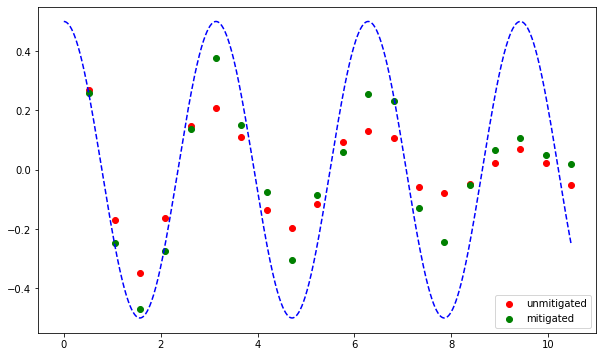

In [21]:
x_ax = np.linspace(0,t[-1],num=1000)

plt.figure(figsize=(10,6))
plt.scatter(t,rho_12_corr,label='unmitigated',c='red')
plt.scatter(t,rho_12_corr_zne,label='mitigated',c='green')
plt.plot(x_ax,corrfunc(x_ax),linestyle='--',c='blue')
#plt.scatter(t,rho_12_uncorr,label='uncorrelated')
#plt.plot(x_ax,uncorrfunc(x_ax),linestyle='--')
plt.legend()
plt.show()